# **2.4M** Params LLM

## Table of Contents

- Prerequisites
- Understanding the Transformer Architecture of LLaMA
  - Pre-normalization Using RMSNorm
  - SwiGLU Activation Function
  - Rotary Embeddings (RoPE)
- Setting the Stage
- Data Preprocessing
- Evaluation Strategy
- Setting Up a Base Neural Network Model
- Replicating LLaMA Architecture
  - RMSNorm for pre-normalization
  - Rotary Embeddings
  - SwiGLU activation function


### SwiGLU Activation Function:

LLaMA introduces the SwiGLU activation function, SwiGLU extends Swish and involves a custom layer with a dense network to split and multiply input activations.

### Rotary Embeddings (RoPE):

Rotary Embeddings, or RoPE, is a type of position embedding used in LLaMA. It encodes absolute positional information using a rotation matrix and naturally includes explicit relative position dependency in self-attention formulations. RoPE offers advantages such as scalability to various sequence lengths and decaying inter-token dependency with increasing relative distances.

This is achieved by encoding relative positions through multiplication with a rotation matrix, resulting in decayed relative distances — a desirable feature for natural language encoding.

The LLaMA introduces the use of the **AdamW optimizer** with specific parameters, efficient implementations such as the causal multi-head attention operator available in the xformers library, and manually implemented backward functions for transformer layers to optimize computation during backward passes.

## Libraries and packages

In [ ]:
# PyTorch for implementing LLM
import torch

# Neural network modules and functions from PyTorch
from torch import nn
from torch.nn import functional as F

# NumPy for numerical operations
import numpy as np

# Matplotlib for plotting Loss etc.
from matplotlib import pyplot as plt

# Time module for tracking execution time
import time

# Pandas for data manipulation and analysis
import pandas as pd

# urllib for handling URL requests (Downloading Dataset)
import urllib.request
import requests
from bs4 import BeautifulSoup
import os
import glob

!pip install PyPDF2
import PyPDF2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 5.0 MB/s eta 0:00:00


In [ ]:
# Configuration object for model parameters
MASTER_CONFIG = {
    # Adding parameters later
}

## Data Preprocessing

**Dataset**:
  - pdf files from Github repo
  - text files from Github repo

In [ ]:
def load_file(file_name):
    """Load content from a text or PDF file."""
    ext = os.path.splitext(file_name)[1].lower()
    try:
        if ext == '.txt':
            with open(file_name, 'r', encoding='utf-8') as f:
                return f.read()
        elif ext == '.pdf':
            with open(file_name, 'rb') as f:
                reader = PyPDF2.PdfReader(f)
                return "\n".join(page.extract_text() or "" for page in reader.pages)
        else:
            print(f"Unsupported file extension: {file_name}")
    except Exception as e:
        print(f"Could not load {file_name}: {e}")
    return ""

def get_github_file_links(repo_url, file_extension):
    """Extracts raw file links from a GitHub directory for a specific file extension."""
    base_raw_url = repo_url.replace("github.com", "raw.githubusercontent.com").replace("/tree/", "/")

    try:
        response = requests.get(repo_url)
        if response.status_code != 200:
            print(f"Failed to access {repo_url}")
            return []

        soup = BeautifulSoup(response.text, 'html.parser')
        file_links = []
        for link in soup.find_all('a', href=True):
            href = link['href']
            if href.endswith(file_extension) and "blob" in href:
                raw_url = href.replace("/blob/", "/")
                full_url = f"https://raw.githubusercontent.com{raw_url}"
                file_links.append(full_url)

        return file_links
    except Exception as e:
        print(f"Error accessing {repo_url}: {e}")
        return []

def download_file(url, local_path):
    """Download a file from a URL."""
    try:
        urllib.request.urlretrieve(url, local_path)
        print(f"Downloaded: {local_path}")
    except Exception as e:
        print(f"Failed to download {url}: {e}")

def download_all_files(repo_url, local_folder, file_extension):
    """Download all files of a given extension from a GitHub repo directory."""
    if not os.path.exists(local_folder):
        os.makedirs(local_folder)

    file_links = get_github_file_links(repo_url, file_extension)
    downloaded_files = []

    for file_link in file_links:
        file_name = os.path.join(local_folder, os.path.basename(file_link))
        download_file(file_link, file_name)
        downloaded_files.append(file_name)

    return downloaded_files

def load_and_combine_data(text_repo=None, text_folder="text_files", pdf_repo=None, pdf_folder="pdf_files"):
    """Load and combine data from all text and PDF files."""
    text_files = download_all_files(text_repo, text_folder, ".txt") if text_repo else glob.glob(os.path.join(text_folder, "*.txt"))
    pdf_files = download_all_files(pdf_repo, pdf_folder, ".pdf") if pdf_repo else glob.glob(os.path.join(pdf_folder, "*.pdf"))

    combined_text = "\n".join(load_file(f) for f in text_files + pdf_files if load_file(f))

    return combined_text

# Example GitHub repository URLs
# text_repo = "https://github.com/anish3565/Test-datasets/tree/main/text-dataset"
text_repo = "https://github.com/anish3565/Test-datasets/tree/main/text-dataset"
pdf_repo = "https://github.com/anish3565/Test-datasets/tree/main/pdf-dataset"  # Update if needed

# Load and combine dataset from text and PDF sources
combined_text = load_and_combine_data(text_repo, "text_files", pdf_repo, "pdf_files")

# Create a sorted list of unique characters in the dataset
vocab = sorted(set(combined_text))

# Output vocabulary details
print('First 10 characters in the vocab list:', vocab[:10])
print('Total number of characters in dataset (Vocabulary Size):', len(vocab))

Downloaded: text_files/basics.txt
Downloaded: text_files/basics.txt
Downloaded: text_files/input2.txt
Downloaded: text_files/input2.txt
Downloaded: text_files/sample.txt
Downloaded: text_files/sample.txt
Downloaded: pdf_files/11_page_notes.pdf
Downloaded: pdf_files/11_page_notes.pdf
Downloaded: pdf_files/Introduction_to_Quantum_Computing.pdf
Downloaded: pdf_files/Introduction_to_Quantum_Computing.pdf
Downloaded: pdf_files/basics_of_qc.pdf
Downloaded: pdf_files/basics_of_qc.pdf
Downloaded: pdf_files/intro_to_qc.pdf
Downloaded: pdf_files/intro_to_qc.pdf
Downloaded: pdf_files/p165.pdf
Downloaded: pdf_files/p165.pdf
Downloaded: pdf_files/qc_pdf.pdf
Downloaded: pdf_files/qc_pdf.pdf
Downloaded: pdf_files/qcnotes.pdf
Downloaded: pdf_files/qcnotes.pdf
Downloaded: pdf_files/quantum-notes.pdf
Downloaded: pdf_files/quantum-notes.pdf
First 10 characters in the vocab list: ['\x00', '\x01', '\x02', '\x03', '\x04', '\x05', '\x06', '\x07', '\x08', '\t']
Total number of characters in dataset (Vocabular

Creating mappings between integers to characters (**itos**) and characters to integers (**stoi**).

In [ ]:
# Mapping integers to characters (itos)
itos = {i: ch for i, ch in enumerate(vocab)}

# Mapping characters to integers (stoi)
stoi = {ch: i for i, ch in enumerate(vocab)}

#### Character-level tokenizer

Encode and decode functions:

In [ ]:
# Encode function: Converts a string to a list of integers using the mapping stoi
def encode(s):
    return [stoi[ch] for ch in s]

# Decode function: Converts a list of integers back to a string using the mapping itos
def decode(l):
    return ''.join([itos[i] for i in l])

# # Example: Encode the string "hello" and then decode the result
# decode(encode("morning"))

Converting our dataset into a torch tensor using **PyTorch**:

Establish two parameters crucial for this process (**batch_size** and **context_window**):

- **batch_size** determines how many batches are processed at each random split

- **context_window** specifies the number of characters in each input (x) and target (y) sequence of each batch.




Random sample from the train split of batch 8 and context window 16 from our dataset:

In [ ]:
# Convert the dataset into a torch tensor with specified data type (dtype)
dataset = torch.tensor(encode(combined_text), dtype=torch.int32)

# Define MASTER_CONFIG with all required parameters at once
MASTER_CONFIG = {
    "vocab_size": len(vocab),
    "batch_size": 8,          # Number of batches to be processed at each random split
    "context_window": 16      # Number of characters in each input (x) and target (y) sequence of each batch
}

# Compute the total number of tokens
num_tokens = dataset.numel()

# Display the shape and token count in both raw form and millions
print(f"torch.Size('{dataset.shape}') indicates that it has {num_tokens} tokens (~{num_tokens / 1_000_000:.2f}M).")

torch.Size('torch.Size([3823085])') indicates that it has 3823085 tokens (~3.82M).


In [ ]:
# Function to get batches for training, validation, or testing
def get_batches(data, split, batch_size, context_window, config=MASTER_CONFIG):
    # Split the dataset into training, validation, and test sets
    train = data[:int(.8 * len(data))]
    val = data[int(.8 * len(data)): int(.9 * len(data))]
    test = data[int(.9 * len(data)):]

    # Determine which split to use
    batch_data = train
    if split == 'val':
        batch_data = val
    if split == 'test':
        batch_data = test

    # Pick random starting points within the data
    ix = torch.randint(0, batch_data.size(0) - context_window - 1, (batch_size,))

    # Create input sequences (x) and corresponding target sequences (y)
    x = torch.stack([batch_data[i:i+context_window] for i in ix]).long()
    y = torch.stack([batch_data[i+1:i+context_window+1] for i in ix]).long()

    return x, y

In [ ]:
# Obtain batches for training using the specified batch size and context window
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

# Decode the sequences to obtain the corresponding text representations
decoded_samples = [(decode(xs[i].tolist()), decode(ys[i].tolist())) for i in range(len(xs))]

# Print the random sample
print(decoded_samples)

[('roximately compu', 'oximately comput'), ('ric Bosonic\nCode', 'ic Bosonic\nCodes'), ('oduct of two ind', 'duct of two inde'), ('\n76\n•BQP (bounde', '76\n•BQP (bounded'), (' lower bound.\nEx', 'lower bound.\nExe'), ('l locality such ', ' locality such t'), (' (This is not ob', '(This is not obv'), ('tes\naddition mod', 'es\naddition modu')]


## Evaluation Strategy

Function to evaluating the architecture.

In [ ]:
@torch.no_grad()  # Don't compute gradients for this function
def evaluate_loss(model, config=MASTER_CONFIG):
    # Placeholder for the evaluation results
    out = {}

    # Set the model to evaluation mode
    model.eval()

    # Iterate through training and validation splits
    for split in ["train", "val"]:
        # Placeholder for individual losses
        losses = []

        # Generate 10 batches for evaluation
        for _ in range(10):
            # Get input sequences (xb) and target sequences (yb)
            xb, yb = get_batches(dataset, split, config['batch_size'], config['context_window'])

            # Perform model inference and calculate the loss
            _, loss = model(xb, yb)

            # Append the loss to the list
            losses.append(loss.item())

        # Calculate the mean loss for the split and store it in the output dictionary
        out[split] = np.mean(losses)

    # Set the model back to training mode
    model.train()

    return out

Using the **loss** as a metric to assess the performance of the model during training iterations.

Function iterates through the training and validation splits, computes the mean loss over 10 batches for each split, and finally returns the results. The model is then set back to training mode with **model.train()**.

## Setting Up a Base Neural Network Model

The embedding layer has some vocabulary size, representing the characters in our dataset.


- For base model using **ReLU** as the activation function in the linear layers,
- then using **SwiGLU**, similar as LLaMA.



A forward function within our NN model

In [ ]:
# Definition of a basic neural network class
class SimpleBrokenModel(nn.Module):
    def __init__(self, config=MASTER_CONFIG):
        super().__init__()
        self.config = config

        # Embedding layer to convert character indices to vectors
        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])

        # Linear layers for modeling relationships between features
        # (to be updated with SwiGLU activation function as in LLaMA)
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),  # Currently using ReLU, will be replaced with SwiGLU as in LLaMA
            nn.Linear(config['d_model'], config['vocab_size']),
        )

        # Print the total number of model parameters
        print("Model parameters:", sum([m.numel() for m in self.parameters()]))

    # Forward pass function for the base model
    def forward(self, idx, targets=None):
        # Embedding layer converts character indices to vectors
        x = self.embedding(idx)

        # Linear layers for modeling relationships between features
        a = self.linear(x)

        # Apply softmax activation to obtain probability distribution
        logits = F.softmax(a, dim=-1)

        # If targets are provided, calculate and return the cross-entropy loss
        if targets is not None:
            # Reshape logits and targets for cross-entropy calculation
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        # If targets are not provided, return the logits
        else:
            return logits

This forward pass function,
- takes character indices (idx) as input,
- applies the embedding layer,
- passes the result through linear layers,
- applies a softmax activation to obtain a probability distribution (logits).

If targets are provided,
- calculates the cross-entropy loss and returns both logits and loss.

If targets are not provided,
- it returns only the logits.

To instantiate this model, we can directly invoke the class and print the total number of parameters in our Simple Neural Network Model.

Dimensions of linear layers: 128

In [ ]:
# Update MASTER_CONFIG with model and training parameters
MASTER_CONFIG.update({
    'd_model': 128,         # Dimension of linear layers
    'epochs': 1000,         # Number of training epochs
    'log_interval': 10,     # Log information every 10 batches
    'batch_size': 32,       # Batch size
})

# Instantiate the model using the final updated MASTER_CONFIG
model = SimpleBrokenModel(MASTER_CONFIG)

# Print total number of parameters in the model
print("Total number of parameters in the Simple Neural Network Model:",
      sum(p.numel() for p in model.parameters()))

# Define the Adam optimizer for model parameters
optimizer = torch.optim.Adam(model.parameters())

Model parameters: 97981
Total number of parameters in the Simple Neural Network Model: 97981


To train the base model and note its performance, we need to specify some parameters.
- Training for a total of 1000 epochs
- Increasing the batch size to 32 from 8
- setting the log_interval to 10, indicating that the code will print or log information about the training progress every 10 batches.

For optimization, using the **Adam optimizer**.

Executing the training process and capture the loss from our base model, including the total number of parameters.

Initial cross-entropy loss before training: **5.76**
Epoch 0 | Validation Loss: 5.76 | Time 0.21s | ETA: 21.28s
Epoch 10 | Validation Loss: 5.75 | Time 0.10s | ETA: 9.86s
Epoch 20 | Validation Loss: 5.72 | Time 0.08s | ETA: 8.01s
Epoch 30 | Validation Loss: 5.67 | Time 0.09s | ETA: 9.04s
Epoch 40 | Validation Loss: 5.62 | Time 0.08s | ETA: 7.95s
Epoch 50 | Validation Loss: 5.58 | Time 0.09s | ETA: 8.33s
Epoch 60 | Validation Loss: 5.57 | Time 0.08s | ETA: 7.30s
Epoch 70 | Validation Loss: 5.55 | Time 0.08s | ETA: 7.71s
Epoch 80 | Validation Loss: 5.56 | Time 0.08s | ETA: 7.68s
Epoch 90 | Validation Loss: 5.56 | Time 0.08s | ETA: 7.55s
Epoch 100 | Validation Loss: 5.54 | Time 0.09s | ETA: 8.31s
Epoch 110 | Validation Loss: 5.54 | Time 0.09s | ETA: 7.86s
Epoch 120 | Validation Loss: 5.54 | Time 0.08s | ETA: 6.81s
Epoch 130 | Validation Loss: 5.54 | Time 0.09s | ETA: 7.40s
Epoch 140 | Validation Loss: 5.54 | Time 0.08s | ETA: 6.91s
Epoch 150 | Validation Loss: 5.54 | Time 0.08s | ETA: 7.0

<Axes: title={'center': 'Validation Loss over Training'}, xlabel='epoch'>

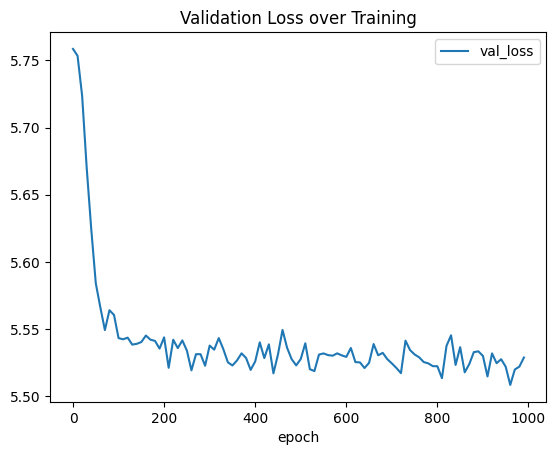

In [ ]:
import time
import torch
import pandas as pd

# Function to perform training
def train(model, optimizer, scheduler=None, config=MASTER_CONFIG, print_logs=True):
    """Train the model and log cross-entropy loss dynamically."""

    # Placeholder for storing losses
    losses = []

    # Start tracking time
    start_time = time.time()

    # Evaluate initial cross-entropy loss before training
    initial_loss = evaluate_loss(model)['val']
    print(f"Initial cross-entropy loss before training: **{initial_loss:.2f}**")

    # Iterate through epochs
    for epoch in range(config['epochs']):
        # Zero out gradients
        optimizer.zero_grad()

        # Obtain batches for training
        xs, ys = get_batches(dataset, 'train', config['batch_size'], config['context_window'])

        # Forward pass through the model to calculate logits and loss
        logits, loss = model(xs, targets=ys)

        # Backward pass and optimization step
        loss.backward()
        optimizer.step()

        # If a learning rate scheduler is provided, adjust the learning rate
        if scheduler:
            scheduler.step()

        # Log progress every specified interval
        if epoch % config['log_interval'] == 0:
            # Calculate batch time
            batch_time = time.time() - start_time

            # Evaluate loss on validation set
            val_loss = evaluate_loss(model)['val']
            losses.append({'epoch': epoch, 'val_loss': val_loss})

            # Print progress logs
            if print_logs:
                print(f"Epoch {epoch} | Validation Loss: {val_loss:.2f} | Time {batch_time:.2f}s | "
                      f"ETA: {batch_time * (config['epochs'] - epoch) / config['log_interval']:.2f}s")

            # Reset the timer
            start_time = time.time()

            # Print learning rate if a scheduler is provided
            if scheduler:
                print(f"Learning Rate: {scheduler.get_last_lr()[0]:.6f}")

    # Evaluate final cross-entropy loss
    final_loss = losses[-1]['val_loss']
    print(f"Final cross-entropy loss after {config['epochs']} epochs: **{final_loss:.2f}**")

    # Return a plot of validation losses
    return pd.DataFrame(losses).plot(x="epoch", y="val_loss", title="Validation Loss over Training")

# Execute the training process
train(model, optimizer)

Softmax layer on the logits, transforms a vector of numbers into a probability distribution.

Using the built-in F.cross_entropy function, we pass in the unnormalized logits.

**"generate" function**:

In [ ]:
def generate(model, prompt, config=MASTER_CONFIG, max_new_tokens=1000, temperature=0.5, top_p=0.9):
    # Initialize with prompt tokens
    idx = torch.tensor(encode(prompt), dtype=torch.long).unsqueeze(0)  # Shape: (1, prompt_length)

    for _ in range(max_new_tokens):
        # Use only the last context_window tokens for conditioning
        idx_cond = idx[:, -config['context_window']:]
        logits = model(idx_cond)

        # Scale the logits by temperature: lower temperature makes predictions more confident
        last_logits = logits[:, -1, :] / temperature

        # Convert logits to probabilities using softmax
        probs = F.softmax(last_logits, dim=-1)

        # Apply top-p (nucleus) sampling
        sorted_probs, sorted_indices = torch.sort(probs, descending=True)
        cumulative_probs = torch.cumsum(sorted_probs, dim=-1)
        # Identify tokens to remove (those beyond the cumulative probability threshold)
        sorted_indices_to_remove = cumulative_probs > top_p
        sorted_indices_to_remove[..., 0] = 0  # Ensure at least one token remains
        indices_to_remove = sorted_indices[sorted_indices_to_remove]
        probs[:, indices_to_remove] = 0
        # Renormalize probabilities
        probs = probs / probs.sum(dim=-1, keepdim=True)

        # Sample the next token from the filtered distribution
        next_token = torch.multinomial(probs, num_samples=1)
        # Append the new token to the sequence
        idx = torch.cat([idx, next_token], dim=-1)

    # Decode the full token sequence into a string
    return decode(idx.squeeze(0).tolist())

## LLaMA Architecture

 1. RMSNorm for pre-normalization

 2. Rotary embeddings

 3. SwiGLU activation function

### RMSNorm for pre-normalization:

We are defining an RMSNorm function with the following functionalities:

In [ ]:
class RMSNorm(nn.Module):
    def __init__(self, layer_shape, eps=1e-8, bias=False):
        super(RMSNorm, self).__init__()

        # Registering a learnable parameter 'scale' as a parameter of the module
        self.register_parameter("scale", nn.Parameter(torch.ones(layer_shape)))

    def forward(self, x):
        """
        Assumes shape is (batch, seq_len, d_model)
        """
        # Calculating the Frobenius norm, RMS = 1/sqrt(N) * Frobenius norm
        ff_rms = torch.linalg.norm(x, dim=(1,2)) * x[0].numel() ** -.5

        # Normalizing the input tensor 'x' with respect to RMS
        raw = x / ff_rms.unsqueeze(-1).unsqueeze(-1)

        # Scaling the normalized tensor using the learnable parameter 'scale'
        return self.scale[:x.shape[1], :].unsqueeze(0) * raw

Defining the RMSNorm class. During initialization, it registers a scale parameter.

- In the forward pass, it calculates the **Frobenius norm** of the input tensor and then normalizes the tensor.
- Finally, the tensor is scaled by the registered scale parameter.
- This function is designed for use in LLaMA to replace the LayerNorm operation.

Incorporating the first implementation concept of LLaMA, which is **RMSNorm**, into our simple NN model:

Executing the modified NN model with RMSNorm and observing the updated number of parameters in the model, along with the loss:

The validation loss decreases, and the parameters of updated LLM now total approximately 35,000.

### **Rotary Embeddings:**

RoPE is embedding the position of a token in a sequence by rotating the embedding, applying a different rotation at each position.

In [ ]:
def get_rotary_matrix(context_window, embedding_dim):
    # Initialize a tensor for the rotary matrix with zeros
    R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)

    # Loop through each position in the context window
    for position in range(context_window):
        # Loop through each dimension in the embedding
        for i in range(embedding_dim // 2):
            # Calculate the rotation angle (theta) based on the position and embedding dimension
            theta = 10000. ** (-2. * (i - 1) / embedding_dim)
            # Calculate the rotated matrix elements using sine and cosine functions
            m_theta = position * theta
            R[position, 2 * i, 2 * i] = np.cos(m_theta)
            R[position, 2 * i, 2 * i + 1] = -np.sin(m_theta)
            R[position, 2 * i + 1, 2 * i] = np.sin(m_theta)
            R[position, 2 * i + 1, 2 * i + 1] = np.cos(m_theta)
    return R

Rotary matrix generated based on the specified context window and embedding dimension, following the proposed RoPE implementation.

Like the architecture of transformers, which involves attention heads, similarly creating attention heads when replicating LLaMA.

Creating a single **masked attention head** using the get_rotary_matrix function previously developed for rotary embeddings:

In [ ]:
class RoPEMaskedAttentionHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        # Linear transformation for query
        self.w_q = nn.Linear(config['d_model'], config['d_model'], bias=False)
        # Linear transformation for key
        self.w_k = nn.Linear(config['d_model'], config['d_model'], bias=False)
        # Linear transformation for value
        self.w_v = nn.Linear(config['d_model'], config['d_model'], bias=False)
        # Obtain rotary matrix for positional embeddings
        self.R = get_rotary_matrix(config['context_window'], config['d_model'])

    def forward(self, x, return_attn_weights=False):
        # x: input tensor of shape (batch, sequence length, dimension)

        b, m, d = x.shape  # batch size, sequence length, dimension

        # Linear transformations for Q, K, and V
        q = self.w_q(x)
        k = self.w_k(x)
        v = self.w_v(x)

        # Rotate Q and K using the RoPE matrix
        q_rotated = (torch.bmm(q.transpose(0, 1), self.R[:m])).transpose(0, 1)
        k_rotated = (torch.bmm(k.transpose(0, 1), self.R[:m])).transpose(0, 1)

        # Perform scaled dot-product attention
        activations = F.scaled_dot_product_attention(
            q_rotated, k_rotated, v, dropout_p=0.1, is_causal=True
        )

        if return_attn_weights:
            # Create a causal attention mask
            attn_mask = torch.tril(torch.ones((m, m)), diagonal=0)
            # Calculate attention weights and add causal mask
            attn_weights = torch.bmm(q_rotated, k_rotated.transpose(1, 2)) / np.sqrt(d) + attn_mask
            attn_weights = F.softmax(attn_weights, dim=-1)
            return activations, attn_weights

        return activations

Now that we have a single masked attention head that returns attention weights, the next step is to create a multi-Head attention mechanism.

In [ ]:
class RoPEMaskedMultiheadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        # Create a list of RoPEMaskedAttentionHead instances as attention heads
        self.heads = nn.ModuleList([
            RoPEMaskedAttentionHead(config) for _ in range(config['n_heads'])
        ])
        self.linear = nn.Linear(config['n_heads'] * config['d_model'], config['d_model'])  # Linear layer after concatenating heads
        self.dropout = nn.Dropout(.1)  # Dropout layer

    def forward(self, x):
        # x: input tensor of shape (batch, sequence length, dimension)

        # Process each attention head and concatenate the results
        heads = [h(x) for h in self.heads]
        x = torch.cat(heads, dim=-1)

        # Apply linear transformation to the concatenated output
        x = self.linear(x)

        # Apply dropout
        x = self.dropout(x)
        return x

In [ ]:
# The master configuration with the number of attention heads
MASTER_CONFIG.update({
    'n_heads': 8,
})

Implemented Rotational Embedding and Multi-head Attention,
using RMSNorm neural network model with the updated code.


Points to be tested:
- performance
- loss
- number of parameters.

Refering to this updated model as **“RopeModel”**

Modified NN model with RMSNorm, Rotational Embeddings and Masked Multi Head Attentions and using 1000 epochs to observe the updated number of parameters in the model, along with the loss:

In [ ]:
# Updating training configuration with more epochs and a logging interval
MASTER_CONFIG.update({
    "epochs": 1000,
    "log_interval": 10,
})

# # Training the model with the updated configuration
# train(model, optimizer)

The validation loss continues to decrease, suggesting that training for more epochs could lead to further loss reduction, although the change is slow.

### SwiGLU activation function:



![[https://arxiv.org/pdf/2002.05202v1.pdf](https://arxiv.org/pdf/2002.05202v1.pdf)](https://cdn-images-1.medium.com/max/27072/1*db6BeMw78FH_ZkVEGIyVPA.png)

In [ ]:
class SwiGLU(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.linear_gate = nn.Linear(size, size)
        self.linear = nn.Linear(size, size)
        self.beta = torch.randn(1, requires_grad=True)

        self.beta = nn.Parameter(torch.ones(1))
        self.register_parameter("beta", self.beta)

    def forward(self, x):
        swish_gate = self.linear_gate(x) * torch.sigmoid(self.beta * self.linear_gate(x))
        out = swish_gate * self.linear(x)
        return out

Integrating SwiGLU equation into our modified LLaMA language model (**RopeModel**).

Executing the modified NN model with RMSNorm, Rotational Embeddings, Masked Multi Head Attentions and SwiGLU to observe the updated number of parameters in the model, along with the loss:

Implemented the key components of the paper, namely RMSNorm, RoPE, and SwiGLU and implementation of these led to a minimal decrease in the loss.

In [ ]:
# Update model configurations for the number of layers
MASTER_CONFIG.update({
    'n_layers': 4,  # Set the number of layers to 4
})

In [ ]:
# add RMSNorm and residual conncection
class LlamaBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.rms = RMSNorm((config['context_window'], config['d_model']))

        self.attention = RoPEMaskedMultiheadAttention(config)
        self.feedforward = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
        )

    def forward(self, x):
        x = self.rms(x) # rms pre-normalization
        x = x + self.attention(x)

        x = self.rms(x) # rms pre-normalization
        x = x + self.feedforward(x)
        return x

Creating an instance of the LlamaBlock class and applying it to a random tensor.

In [ ]:
MASTER_CONFIG

{'vocab_size': 317,
 'batch_size': 32,
 'context_window': 16,
 'd_model': 128,
 'epochs': 1000,
 'log_interval': 10,
 'n_heads': 8,
 'n_layers': 4}

In [ ]:
block = LlamaBlock(MASTER_CONFIG)
block(torch.randn(MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'], MASTER_CONFIG['d_model']));

In [ ]:
# Create an instance of the LlamaBlock class with the provided configuration
block = LlamaBlock(MASTER_CONFIG)

# Generate a random tensor with the specified batch size, context window, and model dimension
random_input = torch.randn(MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'], MASTER_CONFIG['d_model'])

# Apply the LlamaBlock to the random input tensor
output = block(random_input)

In [ ]:
from collections import OrderedDict

MASTER_CONFIG.update({
    'n_layers': 4,
})

class Llama(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        # Embedding layer for token representations
        self.embeddings = nn.Embedding(config['vocab_size'], config['d_model'])
        # Sequential block of LlamaBlocks based on the specified number of layers
        self.llama_blocks = nn.Sequential(
            OrderedDict([(f"llama_{i}", LlamaBlock(config)) for i in range(config['n_layers'])])
        )
        # Feedforward network (FFN) for final output
        self.ffn = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
            nn.Linear(config['d_model'], config['vocab_size']),
        )

        # Print total number of parameters in the model
        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        # Input token indices are passed through the embedding layer
        x = self.embeddings(idx)
        # Process the input through the LlamaBlocks
        x = self.llama_blocks(x)
        # Pass the processed input through the final FFN for output logits
        logits = self.ffn(x)

        # If targets are not provided, return only the logits
        if targets is None:
            return logits
        # If targets are provided, compute and return the cross-entropy loss
        else:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

Executing the modified LLaMA model with RMSNorm, Rotational Embeddings, Masked Multi Head Attentions, SwiGLU and N_layers to observe the updated number of parameters in the model, along with the loss:

model params: 2435010
Initial cross-entropy loss before training: **5.76**
Epoch 0 | Validation Loss: 5.72 | Time 2.04s | ETA: 204.07s
Epoch 10 | Validation Loss: 3.83 | Time 3.20s | ETA: 316.39s
Epoch 20 | Validation Loss: 3.54 | Time 2.95s | ETA: 289.13s
Epoch 30 | Validation Loss: 3.57 | Time 2.89s | ETA: 280.52s
Epoch 40 | Validation Loss: 3.49 | Time 3.59s | ETA: 344.98s
Epoch 50 | Validation Loss: 3.43 | Time 2.74s | ETA: 260.63s
Epoch 60 | Validation Loss: 3.24 | Time 2.74s | ETA: 257.59s
Epoch 70 | Validation Loss: 3.17 | Time 2.90s | ETA: 270.12s
Epoch 80 | Validation Loss: 3.23 | Time 2.98s | ETA: 274.20s
Epoch 90 | Validation Loss: 3.08 | Time 3.67s | ETA: 333.73s
Epoch 100 | Validation Loss: 3.00 | Time 2.90s | ETA: 261.08s
Epoch 110 | Validation Loss: 2.85 | Time 3.24s | ETA: 287.99s
Epoch 120 | Validation Loss: 2.95 | Time 2.95s | ETA: 259.92s
Epoch 130 | Validation Loss: 2.82 | Time 2.75s | ETA: 239.15s
Epoch 140 | Validation Loss: 2.91 | Time 3.84s | ETA: 330.41s
Epoch 

<Axes: title={'center': 'Validation Loss over Training'}, xlabel='epoch'>

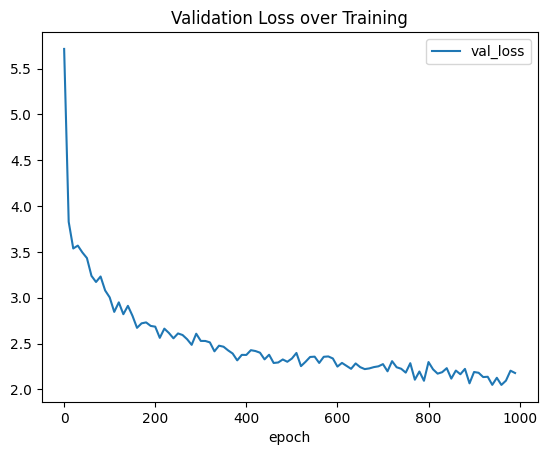

In [ ]:
# Create an instance of RopeModel (RMSNorm, RoPE, Multi-Head, SwiGLU, N_layers)
llama = Llama(MASTER_CONFIG)

# Obtain batches for training
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

# Calculate logits and loss using the model
logits, loss = llama(xs, ys)

# Define the Adam optimizer for model parameters
optimizer = torch.optim.Adam(llama.parameters())

# Train the model
train(llama, optimizer)

Epochs:
- 100 : Works
- 500 : Works
- 1000 : Works
- 700 : Works
- 800 : Works


Initial cross-entropy loss before training: **2.16**
Epoch 0 | Validation Loss: 2.21 | Time 2.04s | ETA: 163.38s
Learning Rate: 0.001000
Epoch 10 | Validation Loss: 2.18 | Time 3.44s | ETA: 271.73s
Learning Rate: 0.001000
Epoch 20 | Validation Loss: 2.11 | Time 2.98s | ETA: 232.26s
Learning Rate: 0.001000
Epoch 30 | Validation Loss: 2.06 | Time 2.71s | ETA: 208.77s
Learning Rate: 0.001000
Epoch 40 | Validation Loss: 2.13 | Time 3.51s | ETA: 267.01s
Learning Rate: 0.001000
Epoch 50 | Validation Loss: 2.13 | Time 2.90s | ETA: 217.36s
Learning Rate: 0.000500
Epoch 60 | Validation Loss: 2.11 | Time 3.56s | ETA: 263.61s
Learning Rate: 0.000500
Epoch 70 | Validation Loss: 2.09 | Time 2.88s | ETA: 210.19s
Learning Rate: 0.000500
Epoch 80 | Validation Loss: 2.01 | Time 2.77s | ETA: 199.37s
Learning Rate: 0.000500
Epoch 90 | Validation Loss: 2.00 | Time 3.73s | ETA: 264.76s
Learning Rate: 0.000500
Epoch 100 | Validation Loss: 2.06 | Time 2.75s | ETA: 192.75s
Learning Rate: 0.000250
Epoch 110 | 

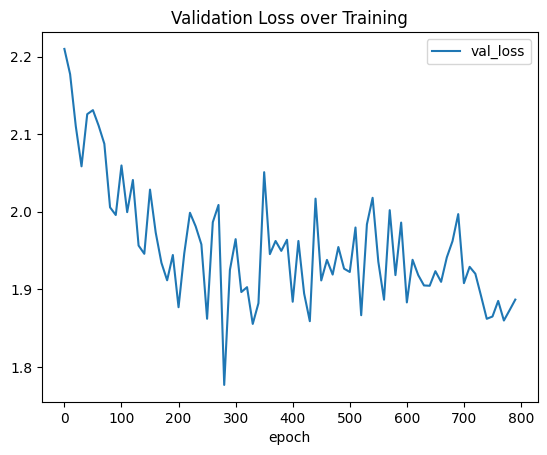

In [ ]:
import time
from torch.optim.lr_scheduler import StepLR

# Update the number of epochs in the configuration
MASTER_CONFIG.update({
    'epochs': 800,
})

# Define a scheduler for learning rate adjustment
scheduler = StepLR(optimizer, step_size=50, gamma=0.5)  # Reduces LR by half every 50 epochs

# Measure start time
start_time = time.time()

# Training the model with scheduler for better optimization
train(llama, optimizer, scheduler=scheduler, config=MASTER_CONFIG, print_logs=True)

# Measure end time
end_time = time.time()

# Calculate and print execution time
execution_time = end_time - start_time
print(f"\nTotal Training Execution Time (with scheduler optimization): {execution_time:.2f} seconds")

- Implementing a scaled-down version of the LLaMA architecture on our custom dataset.

In [ ]:
# Get batches from the test set
xs, ys = get_batches(dataset, 'test', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

# Pass the test data through the LLaMA model
logits, loss = llama(xs, ys)

# Print the loss on the test set
print(loss)

tensor(2.2755, grad_fn=<NllLossBackward0>)


In [ ]:
def qa_system(model, prompt_prefix="Answer the following question: ", config=MASTER_CONFIG):
    model.eval()
    while True:
        question = input("Enter your question (or type 'exit' to quit): ")
        if question.lower() == 'exit':
            break
        prompt = prompt_prefix + question + "\n"
        response = generate(model, prompt, config=config, max_new_tokens=1000, temperature=0.7, top_p=0.9)
        print("Q:", question)
        print("A:", response)

# Q&A system:
qa_system(llama, config=MASTER_CONFIG)

Q: What is quantum computing?
A: Answer the following question: What is quantum computing?
for since probability of mallowing systems in stargestangle, and alloging can be discreted by be are classed sume problems we single with a such a reding a see deach in of concessing of probability a in we can be spection of machod with in operator the and state is a gate of a be of the every the probability of a of example from probability of the sing the outation with an it such the leartors in Sectors reespace supeds the actors call may in in the ach end the to the orrend for the defection the the introlled a computers algorithm the sing the state neart be convect in of in which probability eversible computing expace in the matrix is a supping the introded of the the the can out of probability a convelse with probability of in the the and the the the outs of the of the code for basis called the the extend at when are is of a pille for the sumput send a now contection of bain seard such in a st